In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)
from astropy.io import fits
from astropy.table import Table
import scipy
import matplotlib.pyplot as plt

# %pip install fortranformat
# %pip install rpy2
from survival_analysis import setup, ats_fit, kaplan_meier

hdul = fits.open("Data/SNR-ge5-fullmatch.fits")
dataTable = Table(hdul[1].data)

Aligned_color = 'tab:blue'
MA_color = 'tab:orange'

Error importing in API mode: ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /opt/anaconda3/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
print(len(dataTable))
dataTable

2217


PLATEIFU_1,MANGAID,OBJRA,OBJDEC,LOGMSTARS,SINI,VOPT,RMS,LOGHILIM200KMS,PEAK,SNR,LOGMHI,log_sfr_ha,e_log_sfr_ha,log_sfr_ssp,e_log_sfr_ssp,plateifu_2,GroupID_1,GroupSize_1,plateifu,ang_stellar,ang_stellar_err,ang_ha,ang_ha_err,GroupID,GroupSize
str11,str9,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str128,int32,int32,str12,float32,float32,float32,float32,int32,int32
8150-6103,1-585731,147.14825439453125,33.4216194152832,9.638200759887695,0.9583520889282227,1478.0396,2.32,-999.0,0.3042478,485.4,9.88,-0.4946189,0.057670705,-0.28835812,0.0025660857,8150-6103,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
12483-9102,1-405438,186.45362854003906,33.54685974121094,9.061619758605957,0.7370062470436096,318.88745,4.48,-999.0,0.782437,413.3,9.05,nan,nan,nan,nan,,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
11020-12701,1-591845,202.68707,54.91083,7.456815614022371,0.8350513930740456,62.0,1.4049127,-999.0,0.32036477,227.03181,6.46515,nan,nan,nan,nan,,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8150-3701,1-389720,147.58895874023438,31.487945556640625,7.203427314758301,0.872176468372345,512.1597,2.23,-999.0,0.20727849,185.9,8.3,-1.9529321,0.05829908,-2.1561422,0.02517147,8150-3701,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8554-12704,1-619066,183.03892517089844,36.16889953613281,7.901483535766602,0.658564567565918,163.00435,2.95,-999.0,0.29020908,116.4,7.24,-4.2697535,0.058663238,-3.574569,0.047086872,8554-12704,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8939-12704,1-298537,125.68737030029297,24.29697036743164,10.052289962768555,0.5462271571159363,3853.3162,2.2,-999.0,0.060968317,96.2,10.05,-0.6516772,0.0579155,-0.24537462,0.0018752717,8939-12704,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8727-12705,1-604172,57.1040919143,-6.62606055908,9.95913969401184,0.7989146236328362,6286.6,1.5021833,-999.0,0.12166475,79.99194,10.110007,0.3406327,0.05826904,0.67192465,0.004908738,8727-12705,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8985-12701,1-421314,203.73062133789062,31.39351463317871,9.440648078918457,0.545078456401825,4964.6284,2.64,-999.0,0.063046806,77.2,10.23,-0.34527826,0.05634209,-0.12617646,0.001158293,8985-12701,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648
8332-1902,1-575771,209.270729549,41.8462774355,10.348501516915432,0.7295046752026548,2441.0,1.872,-999.0,0.13656002,73.1,9.792138,-0.15842466,0.0561735,-0.06860747,0.0005294584,8332-1902,-2147483648,-2147483648,,nan,nan,nan,nan,-2147483648,-2147483648


In [3]:
mask = np.array(dataTable['ang_ha'].astype(str) == str(np.nan))
print(len(mask))
print(len(mask[mask == True]))
print(len(mask[mask == False]))
print(f'Percentage of SNR ≥ 5 galaxies exhibiting misalignment: {100 * len(mask[mask == False]) / len(mask)} %')

2217
2173
44
Percentage of SNR ≥ 5 galaxies exhibiting misalignment: 1.9846639603067209 %


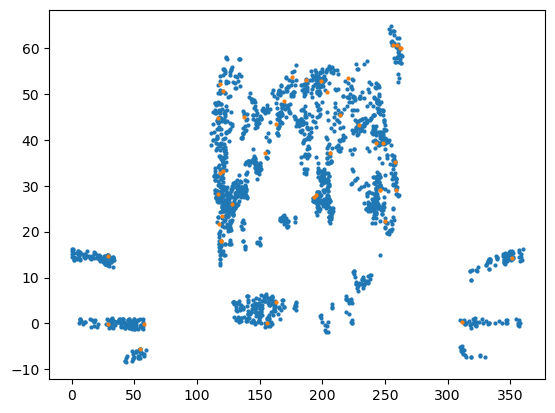

In [4]:
plt.scatter(dataTable['OBJRA'][mask], dataTable['OBJDEC'][mask], label = 'MA', s = 4)
plt.scatter(dataTable['OBJRA'][~mask], dataTable['OBJDEC'][~mask], label = 'Aligned', s = 4)
plt.show()